In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tools import *
import operator
import itertools


In [2]:
train_data=torchvision.datasets.MNIST('./', train=True, download=True,transform=torchvision.transforms.ToTensor())
test_data=torchvision.datasets.MNIST('./', train=False, download=True,transform=torchvision.transforms.ToTensor())
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

In [3]:
train_dict={}
for (data, target) in train_data:
    if  target not in train_dict:
        train_dict[ target]=[]
        train_dict[ target].append(data)
    else:
        train_dict[ target].append(data)

In [3]:
initial_train_data=[]
initial_train_label=[]
for i in range(7):
    for j in range(0,10):
        initial_train_data.append(train_dict[i][j])
        initial_train_label.append(i)
    
print(initial_train_label)

NameError: name 'train_dict' is not defined

In [5]:
initial_train_data_tensor=torch.stack(initial_train_data)
initial_train_label_tensor=torch.tensor(initial_train_label)
train_x=torch.stack([data for (data, target) in train_data])
train_label=torch.tensor([target for (data, target) in train_data])
print(initial_train_data_tensor.size())
print(initial_train_label_tensor.size())

torch.Size([70, 1, 28, 28])
torch.Size([70])


In [1]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 20)
        
        
        self.prior_mu=torch.tensor(np.zeros(200), dtype=torch.float, requires_grad=False)
        self.prior_diag=torch.tensor(np.ones(200), dtype=torch.float, requires_grad=False)
        
        self.q_mu=(torch.randn(200)*0.1).requires_grad_()
#        self.q_diag=torch.exp(torch.randn(200)).requires_grad_()
        
#         self.q_mu=torch.tensor(np.zeros(200), dtype=torch.float, requires_grad=True)
        self.q_diag=torch.tensor(np.ones(200), dtype=torch.float, requires_grad=True)
        params = list(self.parameters()) + [self.q_mu,self.q_diag]
        self.optimizer = optim.Adam(params, lr=0.001)
        self.feature_optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.final_optimizer = optim.Adam([ self.q_mu, self.q_diag ], lr=0.001)

    def forward(self, x, final_weight):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x =self.fc2(x)
        x= torch.matmul(x,final_weight)
        return F.log_softmax(x,dim=-1)
    
    
    def feature_forward(self, x ):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x =  self.fc2(x)
        return x
    
    def predict(self,x):
        with torch.no_grad():
            eps=torch.tensor(np.random.normal([200]),dtype=torch.float)
            final_weight_sample= (self.q_mu+eps*torch.sqrt(self.q_diag)).view(20,10)
            output = torch.exp(self.forward(x,final_weight_sample))
            pred = output.data.max(dim=1, keepdim=True)[1]
            return pred
        
    def test_prediction(self, x):
        with torch.no_grad():
            final_weight_mean=self.q_mu.view(20,10)
            output = torch.exp(self.forward(x,final_weight_mean))
            pred = output.data.max(dim=1, keepdim=True)[1]
            return pred
        
        
    def predictive_distribution_entropy(self,x):
        eps=torch.randn([100,200])
        #eps=torch.tensor(np.random.normal(size=[100,200]),dtype=torch.float)
        final_weight_samples=(torch.sqrt(self.q_diag).repeat(100).view(100,200)*eps+self.q_mu).view(100,20,10).permute(0, 2, 1)
        feature_of_data=self.feature_forward(x)[0]
        output_logit=final_weight_samples@feature_of_data
        output_dis=torch.distributions.categorical.Categorical(logits=output_logit)
        
        
        sample=output_dis.sample([100]).reshape([-1,1])
        entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
        return entropy
    
    
    def likelihood_eva(self,x,label, sample_num=100, if_online=False):
        
        eps=torch.randn([sample_num,200])
        #eps=torch.tensor(np.random.normal(size=[sample_num,200]),dtype=torch.float)
        final_weight_samples=(torch.sqrt(self.q_diag).repeat(sample_num).view(sample_num,200)*eps+self.q_mu).view(sample_num,20,10).permute(0, 2, 1)
        
#         eps=torch.tensor(np.random.normal(size=[200]),dtype=torch.float)
#         final_weight_samples= (self.q_mu+eps*torch.sqrt(self.q_diag)).view(20,10)
        feature_of_data=self.feature_forward(x)
#         print(feature_of_data.size())
        print(final_weight_samples.size())
        output=torch.mean(F.log_softmax((final_weight_samples@feature_of_data.t()).permute(0, 2, 1),dim=-1),0)
        
        predicted=output.data.max(dim=1, keepdim=True)[1].view(-1)
        accuracy=(predicted == label).sum().item()/label.size(0)
        
        print(output.size())
        nll_loss= F.nll_loss(output,label,reduction='sum')
        if if_online:
            curr_prior_mu = self.q_mu.clone().detach()
            curr_prior_diag= self.q_diag.clone().detach()
            kl=KL_diag_gaussian(self.q_mu,self.q_diag,curr_prior_mu,curr_prior_diag)
        else:
            kl=KL_diag_gaussian(self.q_mu,self.q_diag,self.prior_mu,self.prior_diag)
        neg_elbo=kl+nll_loss
        
        return -neg_elbo,accuracy
    
    
    
    def predictive_distribution_entropy_2(self,x, sample_num=100):
        eps=torch.randn([sample_num,200])
        #eps=torch.tensor(np.random.normal(size=[sample_num,200]),dtype=torch.float)
        final_weight_samples=(torch.sqrt(self.q_diag).repeat(sample_num).view(sample_num,200)*eps+self.q_mu).view(sample_num,20,10).permute(0, 2, 1)
        feature_of_data=self.feature_forward(x)[0]
        
        output_logit=final_weight_samples@feature_of_data
        output_dis=torch.distributions.categorical.Categorical(logits=output_logit)
        
        eps=torch.randn([sample_num,200])
        #eps=torch.tensor(np.random.normal(size=[sample_num,200]),dtype=torch.float)
        final_weight_samples=(torch.sqrt(self.q_diag).repeat(sample_num).view(sample_num,200)*eps+self.q_mu).view(sample_num,20,10).permute(0, 2, 1)
        feature_of_data=self.feature_forward(x)[0]
        output_logit=final_weight_samples@feature_of_data
        output_dis_for_sample=torch.distributions.categorical.Categorical(logits=output_logit)
        
        sample=output_dis_for_sample.sample([sample_num]).reshape([-1,1])
        entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
        return entropy
    
    
#       def lower_bound_entropy(self,x):
#         eps=torch.tensor(np.random.normal(size=[100,200]),dtype=torch.float)
#         final_weight_samples=(torch.sqrt(self.q_diag).repeat(100).view(100,200)*eps+self.q_mu).view(100,20,10).permute(0, 2, 1)
#         feature_of_data=self.feature_forward(x)[0]
#         output_logit=final_weight_samples@feature_of_data
#         output_dis=torch.distributions.categorical.Categorical(logits=output_logit)
#         sample=output_dis.sample([100]).reshape([-1,1])
        
#         eps=torch.tensor(np.random.normal(size=[100,200]),dtype=torch.float)
#         final_weight_samples=(torch.sqrt(self.q_diag).repeat(100).view(100,200)*eps+self.q_mu).view(100,20,10).permute(0, 2, 1)
        
        
        
        
        
        entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
        return entropy
    
    
    
    def online_train(self,x,label,samlpe_num=100):
        train_losses = []
        total_size=x.size(0)
        curr_prior_mu = self.q_mu.clone().detach()
        curr_prior_diag= self.q_diag.clone().detach()
        correct_flag=0

        while correct_flag<5:
            
#             lr = 0.01 * (0.1 ** (it // 2000))
#             for param_group in self.final_optimizer.param_groups:
#                 param_group['lr'] = lr
        
            self.final_optimizer.zero_grad()
            eps=torch.randn([samlpe_num,200])
            #eps=torch.tensor(np.random.normal(size=[sample_num,200]),dtype=torch.float)
            final_weight_samples=(torch.sqrt(self.q_diag).repeat(samlpe_num).view(samlpe_num,200)*eps+self.q_mu).view(samlpe_num,20,10).permute(0, 2, 1)

    #         eps=torch.tensor(np.random.normal(size=[200]),dtype=torch.float)
    #         final_weight_samples= (self.q_mu+eps*torch.sqrt(self.q_diag)).view(20,10)
            feature_of_data=self.feature_forward(x)
    #         print(feature_of_data.size())
            output=torch.mean(F.log_softmax((final_weight_samples@feature_of_data.t()).permute(0, 2, 1),dim=-1),0)

            nll_loss= F.nll_loss(output,label,reduction='sum')
            kl=KL_diag_gaussian(self.q_mu,self.q_diag,curr_prior_mu,curr_prior_diag)
            neg_elbo=kl+nll_loss
            neg_elbo.backward()
            self.final_optimizer.step()
            train_losses.append(neg_elbo.item())
            
            
            if output.data.max(dim=1, keepdim=True)[1].item()==label.item():
                correct_flag+=1
            else:
                correct_flag=0
        print(output.data.max(dim=1, keepdim=True)[1].item())
        plt.plot(train_losses)
        plt.show()
        
        
    
    def pre_train(self,x,label):
        train_losses = []
        batch_size=50
        for epoch in range(0,1000):
            for it in range(0,int(x.size(0)/batch_size)+1):
                index=np.random.choice(x.size(0),batch_size)
                self.optimizer.zero_grad()

    #             conditional_loss=0
    #             for i in range(0,10):
                eps=torch.tensor(np.random.normal(size=[200]),dtype=torch.float)
                final_weight_sample= (self.q_mu+eps*torch.sqrt(self.q_diag)).view(20,10)
                output = self.forward(x[index],final_weight_sample)
                nll_loss= F.nll_loss(output,label[index],reduction='sum')*(float(x.size(0))/float(batch_size))
                kl=KL_diag_gaussian(self.q_mu,self.q_diag,self.prior_mu,self.prior_diag)
                neg_elbo=kl+nll_loss
                neg_elbo.backward()
                self.optimizer.step()
                train_losses.append(neg_elbo.item())
        plt.plot(train_losses)
        plt.show()
        
        
    def test(self):
        correct=0
        for data, target in test_loader:
            pred = self.predict(data)
            correct += pred.eq(target.data.view_as(pred)).sum()
            correct_ratio= float(correct)/len(test_loader.dataset)
        return correct_ratio
    

NameError: name 'nn' is not defined

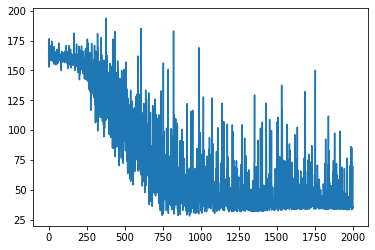

In [84]:
active_bnn = Net()
active_bnn.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [85]:
# active_bnn = Net()
likelihood_of_initial_dataset,accuracy=active_bnn.likelihood_eva(initial_train_data_tensor,initial_train_label_tensor)
print(likelihood_of_initial_dataset)
print(accuracy)

torch.Size([100, 10, 20])
torch.Size([70, 10])
tensor(-11.0317, grad_fn=<NegBackward>)
1.0


8


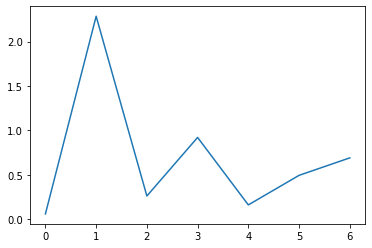

In [93]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn.online_train(x_new,label_new,samlpe_num=1)

8


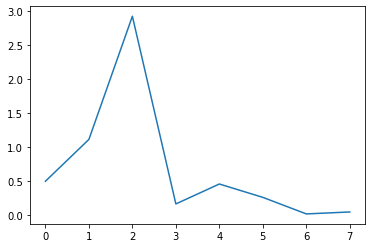

In [103]:
x_new=train_dict[8][21].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn.online_train(x_new,label_new,samlpe_num=1)

In [104]:
# print(active_bnn.test_prediction(initial_train_data_tensor))
# # print(active_bnn.predict(initial_train_data_tensor))
print(active_bnn.predictive_distribution_entropy(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][15]))
print('yo')
print(active_bnn.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.3696, grad_fn=<NegBackward>)
tensor(1.2187, grad_fn=<NegBackward>)
tensor(0.9190, grad_fn=<NegBackward>)
tensor(0.9224, grad_fn=<NegBackward>)
tensor(1.0801, grad_fn=<NegBackward>)
tensor(0.3228, grad_fn=<NegBackward>)
tensor(0.3386, grad_fn=<NegBackward>)
tensor(1.7187, grad_fn=<NegBackward>)
tensor(0.3736, grad_fn=<NegBackward>)
yo
tensor(0.2779, grad_fn=<NegBackward>)
tensor(1.1347, grad_fn=<NegBackward>)
tensor(0.9718, grad_fn=<NegBackward>)
tensor(1.1868, grad_fn=<NegBackward>)
tensor(1.0787, grad_fn=<NegBackward>)
tensor(0.3747, grad_fn=<NegBackward>)
tensor(0.3007, grad_fn=<NegBackward>)
tensor(1.7846, grad_fn=<NegBackward>)
tensor(0.4392, grad_fn=<NegBackward>)


In [73]:
active_bnn.test_prediction(x_new)

tensor([[8]])

In [17]:
# active_bnn = Net()
likelihood_of_initial_dataset,accuracy=active_bnn.likelihood_eva(initial_train_data_tensor,initial_train_label_tensor)
print(likelihood_of_initial_dataset)
print(accuracy)

torch.Size([100, 10, 20])
torch.Size([70, 10])
tensor(-21.4444, grad_fn=<NegBackward>)
1.0


In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

# active_bnn.online_train(x_new,label_new)

likelihood_of_initial_dataset,accuracy=active_bnn.likelihood_eva(initial_train_data_tensor,initial_train_label_tensor,sample_num=100, if_online=True)
print(likelihood_of_initial_dataset)
print(accuracy)

In [ ]:
x_new=train_dict[4][16].view(-1,1,28,28)
label_new=torch.tensor([4])

active_bnn.online_train(x_new,label_new)

likelihood_of_initial_dataset,accuracy=active_bnn.likelihood_eva(initial_train_data_tensor,initial_train_label_tensor,sample_num=100, if_online=True)
print(likelihood_of_initial_dataset)
print(accuracy)

In [ ]:
# print(active_bnn.test_prediction(initial_train_data_tensor))
# # print(active_bnn.predict(initial_train_data_tensor))
print(active_bnn.predictive_distribution_entropy(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][15]))
print('yo')
print(active_bnn.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
likelihood_of_initial_dataset=active_bnn.likelihood_eva(initial_train_data_tensor,initial_train_label_tensor,sample_num=100, if_online=True)
print(likelihood_of_initial_dataset)

In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn.online_train(x_new,label_new)



In [ ]:
likelihood_of_initial_dataset=active_bnn.likelihood_eva(initial_train_data_tensor,initial_train_label_tensor,sample_num=100, if_online=True)
print(likelihood_of_initial_dataset)

In [ ]:
print(active_bnn.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][21].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn.online_train(x_new,label_new)

In [ ]:
print(active_bnn.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[4][16].view(-1,1,28,28)
label_new=torch.tensor([4])

active_bnn.online_train(x_new,label_new)

In [ ]:
print(active_bnn.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn.online_train(x_new,label_new)

In [ ]:
print(active_bnn.predictive_distribution_entropy(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][15]))

In [ ]:
for i in range(0,30):
    print(i)
    print(active_bnn.predictive_distribution_entropy(train_dict[1][i]))
    print(active_bnn.predictive_distribution_entropy(train_dict[8][i]))

In [ ]:
for i in range(0,30):
    x_new=train_dict[8][i].view(-1,1,28,28)
    label_new=torch.tensor([8])

    active_bnn.online_train(x_new,label_new)

In [ ]:
for i in range(0,30):
    print(i)
    print(active_bnn.predictive_distribution_entropy(train_dict[1][i]))
    print(active_bnn.predictive_distribution_entropy(train_dict[8][i]))